In [100]:
import pandas as pd
import numpy as np
import json
import nltk
from nltk.corpus import stopwords
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
%matplotlib inline
pd.set_option('display.max_colwidth',300)

In [8]:
#Load Data
meta_data_df = pd.read_csv("./MovieSummaries/movie.metadata.tsv", 
                           sep='\t',
                           header=None,
                           names = [ 'Wikipedia_movie_ID',
                                    'Freebase_movie_ID',
                                    'Movie_name',
                                    'Movie_release_date',
                                    'Movie_box_office_revenue',
                                    'Movie_runtime',
                                    'Movie_languages',
                                    'Movie_countries',
                                    'Movie_genres'])
meta_data_df.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [11]:
movie_plot_df = pd.read_csv("./MovieSummaries/plot_summaries.txt",
                            sep='\t',
                            header=None,
                           names = ['Wikipedia_movie_ID','plot'])
movie_plot_df.head()

,Wikipedia_movie_ID,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole..."
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e..."
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo..."
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r..."


In [15]:
movie_plot_genre_df = pd.merge(meta_data_df,movie_plot_df,
                               on='Wikipedia_movie_ID',how='inner')
movie_plot_genre_df = movie_plot_genre_df[['Wikipedia_movie_ID',
                                          'Movie_genres',
                                          'plot']]
movie_plot_genre_df.head()

,Wikipedia_movie_ID,Movie_genres,plot
0,975900,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}","Set in the second half of the 22nd century, the film depicts Mars as a planet that has been 84% terraformed, allowing humans to walk on the surface without wearing pressure suits. The Martian society has become largely matriarchal, with women in most positions of authority. The story concerns a ..."
1,9363483,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}","A series of murders of rich young women throughout Arizona bear distinctive signatures of a serial killer. Clues lead Detective Charles Mendoza to visit Paul White, a sound expert installing hi-fi systems in wealthy people's homes. His special talent is to make a noise which echoes through the a..."
2,261236,"{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustrated and leaves her arrogant husband. She is drawn to the idea of becoming a call girl. With the aid of a prostitute named Yvonne, Eva learns the basics and then they both set out looking for Johns together. She meets a charming man who she falls in l..."
3,18998739,"{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fantasy"", ""/m/03k9fj"": ""Adventure"", ""/m/03q4nz"": ""World cinema""}","Every hundred years, the evil Morgana returns to claim Fingall's talisman from the wizard Merlin, with which she intends to destroy the world. For the last fourteen hundred years she has failed... now she intends to conquer all. Young Ben Clark moves with his parents to a new town, where he be..."
4,6631279,"{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ""Ensemble Film"", ""/m/01t_vv"": ""Comedy-drama"", ""/m/07s9rl0"": ""Drama"", ""/m/01z4y"": ""Comedy"", ""/m/068d7h"": ""Romantic drama"", ""/m/02l7c8"": ""Romance Film""}","Adam, a San Francisco-based artist who works as a cab driver on the side, is having a hard time committing to his girlfriend, Nina. She wants to take their relationship to the next level, but he hasn't really gotten over his ex-girlfriend, Kate, who left him for another woman and is reluctant to..."


In [17]:
# Genre is in dictionary format
movie_plot_genre_df['Movie_genres'][0]

'{"/m/01jfsb": "Thriller", "/m/06n90": "Science Fiction", "/m/03npn": "Horror", "/m/03k9fj": "Adventure", "/m/0fdjb": "Supernatural", "/m/02kdv5l": "Action", "/m/09zvmj": "Space western"}'

In [18]:
#Let's confirm the type
type(json.loads(movie_plot_genre_df['Movie_genres'][0]))

dict

In [20]:
#Read genre in dict format.
json.loads(movie_plot_genre_df['Movie_genres'][0]).values()

dict_values(['Thriller', 'Science Fiction', 'Horror', 'Adventure', 'Supernatural', 'Action', 'Space western'])

In [25]:
#Change the data to List format 
genres = []

for i in movie_plot_genre_df['Movie_genres']:
    genres.append(list(json.loads(i).values()))
    
movie_plot_genre_df['genre'] = genres

In [48]:
movie_plot_genre_df[(movie_plot_genre_df['genre'].str.len()==0)].count()

Wikipedia_movie_ID    411
Movie_genres          411
plot                  411
genre                 411
dtype: int64

In [37]:
# Remove movies that don't have any genre associated with them
movie_df = movie_plot_genre_df[~(movie_plot_genre_df['genre'].str.len()==0)]

In [38]:
movie_df.shape, movie_plot_genre_df.shape

((41793, 4), (42204, 4))

In [49]:
# Make a list of movie genres present in the dataset
all_genres = sum(genres,[])
len(set(all_genres))
# The major difference is that sets, unlike lists or 
# tuples, cannot have multiple occurrences of 
# the same element and store unordered values.May 29, 2018

363

In [62]:
# Use nltk.FreqDis() to find frequency of each  genre type
all_genres = nltk.FreqDist(all_genres)
all_genres_df = pd.DataFrame({'Genre':list(all_genres.keys()),
                              'Frequency':list(all_genres.values())})

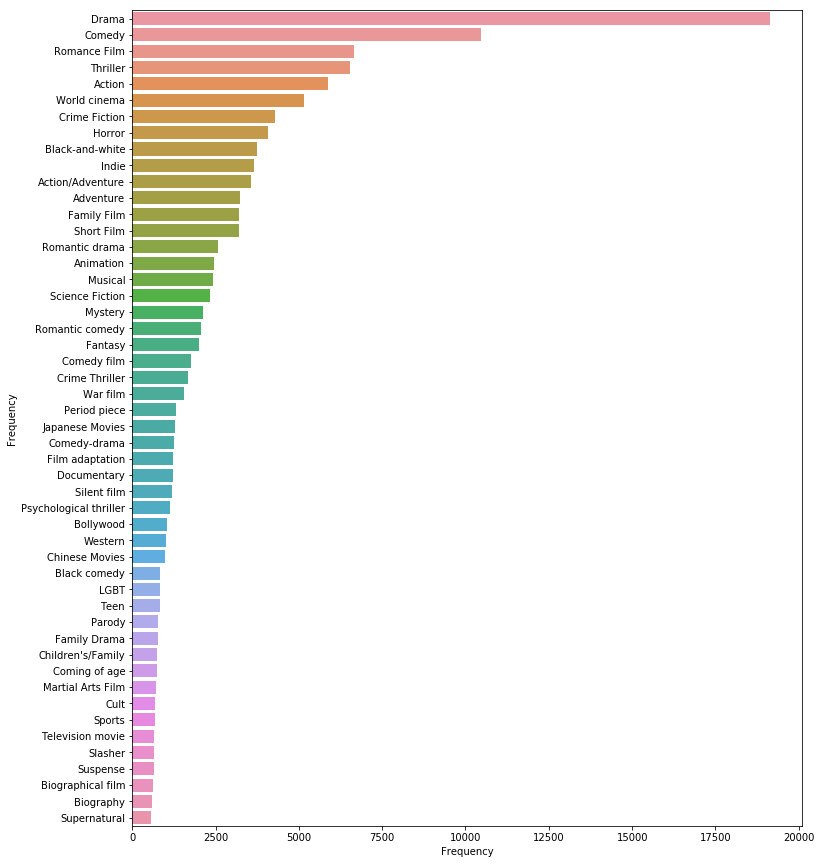

In [72]:
# Let's visulaize the distribution for top 50 genre occurences 
g = all_genres_df.nlargest(columns="Frequency", n =50)
plt.figure(figsize=(12,15))
ax = sns.barplot(data=g,x="Frequency", y="Genre")
ax.set(ylabel = 'Frequency')
plt.show()

In [73]:
#Clean the plot text
def clean_text(text):
#     Clean backslash - apostrophe
    text = re.sub("\'","",text)
#     remove everything except alphabets
    text = re.sub("[^a-zA-Z]"," ",text)
#     remove whitespaces
    text = ' '.join(text.split())
#     convert text to lowercase
    text = text.lower()
    
    return text

In [75]:
movie_df['cleaned_plot'] = movie_df['plot'].apply(lambda x:clean_text(x))
movie_df[['plot','cleaned_plot']].head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,plot,cleaned_plot
0,"Set in the second half of the 22nd century, the film depicts Mars as a planet that has been 84% terraformed, allowing humans to walk on the surface without wearing pressure suits. The Martian society has become largely matriarchal, with women in most positions of authority. The story concerns a ...",set in the second half of the nd century the film depicts mars as a planet that has been terraformed allowing humans to walk on the surface without wearing pressure suits the martian society has become largely matriarchal with women in most positions of authority the story concerns a police offi...
1,"A series of murders of rich young women throughout Arizona bear distinctive signatures of a serial killer. Clues lead Detective Charles Mendoza to visit Paul White, a sound expert installing hi-fi systems in wealthy people's homes. His special talent is to make a noise which echoes through the a...",a series of murders of rich young women throughout arizona bear distinctive signatures of a serial killer clues lead detective charles mendoza to visit paul white a sound expert installing hi fi systems in wealthy peoples homes his special talent is to make a noise which echoes through the air c...
2,"Eva, an upper class housewife, becomes frustrated and leaves her arrogant husband. She is drawn to the idea of becoming a call girl. With the aid of a prostitute named Yvonne, Eva learns the basics and then they both set out looking for Johns together. She meets a charming man who she falls in l...",eva an upper class housewife becomes frustrated and leaves her arrogant husband she is drawn to the idea of becoming a call girl with the aid of a prostitute named yvonne eva learns the basics and then they both set out looking for johns together she meets a charming man who she falls in love wi...
3,"Every hundred years, the evil Morgana returns to claim Fingall's talisman from the wizard Merlin, with which she intends to destroy the world. For the last fourteen hundred years she has failed... now she intends to conquer all. Young Ben Clark moves with his parents to a new town, where he be...",every hundred years the evil morgana returns to claim fingalls talisman from the wizard merlin with which she intends to destroy the world for the last fourteen hundred years she has failed now she intends to conquer all young ben clark moves with his parents to a new town where he befriends his...
4,"Adam, a San Francisco-based artist who works as a cab driver on the side, is having a hard time committing to his girlfriend, Nina. She wants to take their relationship to the next level, but he hasn't really gotten over his ex-girlfriend, Kate, who left him for another woman and is reluctant to...",adam a san francisco based artist who works as a cab driver on the side is having a hard time committing to his girlfriend nina she wants to take their relationship to the next level but he hasnt really gotten over his ex girlfriend kate who left him for another woman and is reluctant to move fo...


In [86]:
def freq_words(x, terms=30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    word_dist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(word_dist.keys()),
                             'frequency': list(word_dist.values())})
    
    #Select top terms frequent words
    d = words_df.nlargest(columns='frequency',n=terms)
    
    #Visualize the words and frequencies 
    plt.figure(figsize=(12,15))
    ax = sns.barplot(data=d, x="frequency",y='word')
    ax.set(ylabel='Word')
    plt.show()

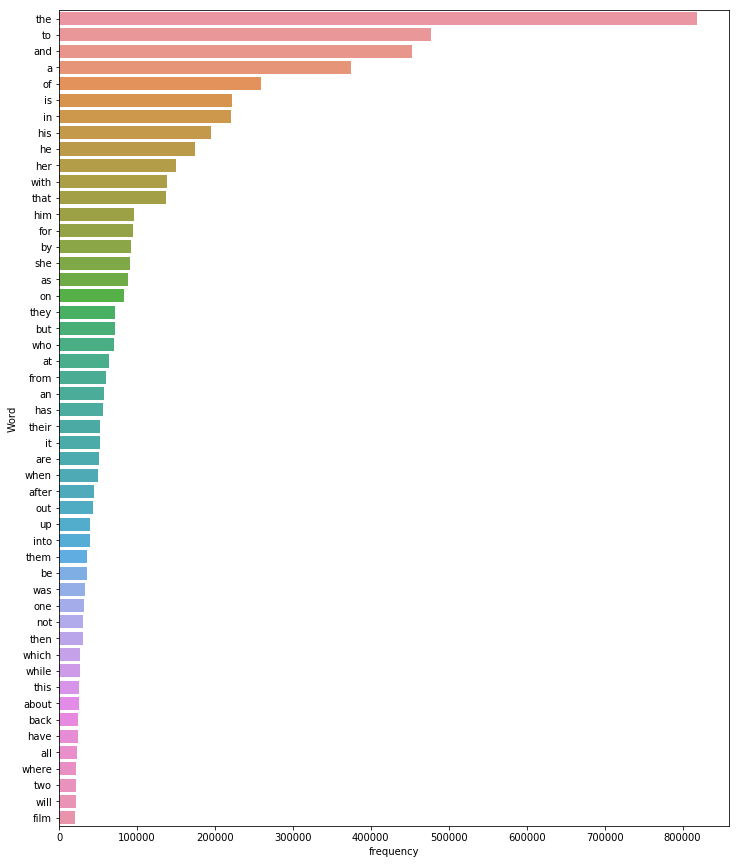

In [89]:
freq_words(movie_df['cleaned_plot'],50)

In [101]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sunita.dwivedi/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [104]:
# Stopwords carry almost no meaning hence should be removed inorder to
# reduce noice.
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

movie_df['cleaned_plot'] = movie_df['cleaned_plot'].apply(
    lambda x:remove_stopwords(x))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


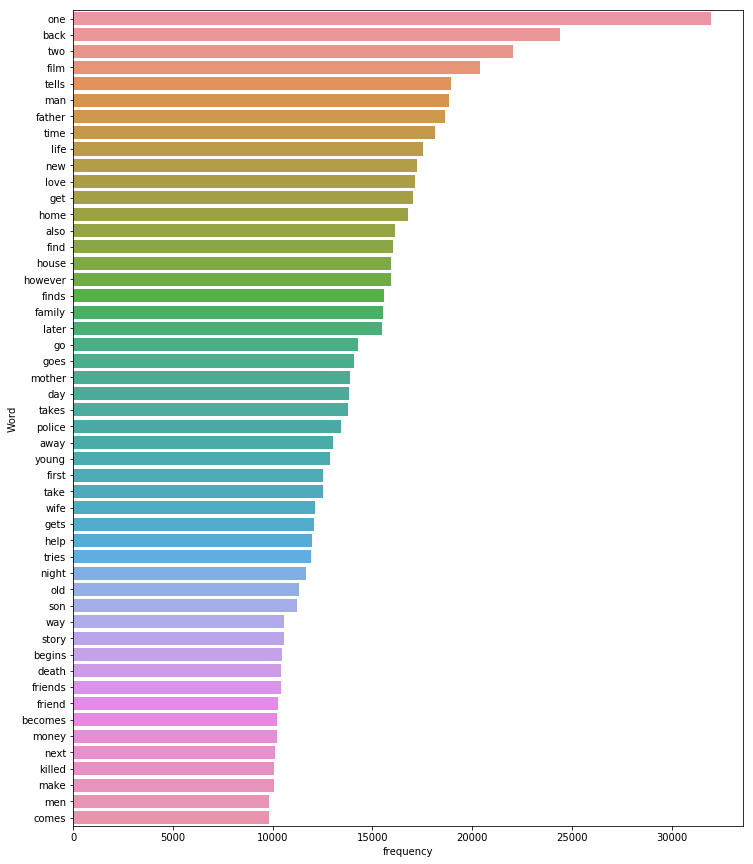

In [106]:
freq_words(movie_df['cleaned_plot'],50)

In [108]:
#Using binary relevance approach to genre we will one hot encode the 
# target variables 
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movie_df['genre'])
# transform traget variable
y = multilabel_binarizer.transform(movie_df['genre'])

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [113]:
# split the data into traning and validation set
xtrain, xval, ytrain, yval = train_test_split(movie_df['cleaned_plot'],y,
                                             test_size=0.2, random_state=9)

In [115]:
# Extract features from cleaned version of te movie plots.
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
val_tfidf = tfidf_vectorizer.transform(xval)
# 10000 most frequent words as features.

In [116]:
# We will have to build a model for every   one-hot encoded traget variable
# as we are using the approach of binary relevance
# Logistic regression models train relatively fast on limited computational
#  power
from sklearn.linear_model import LogisticRegression
#Binar Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [117]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [118]:
#fit the model on trained data
clf.fit(xtrain_tfidf, ytrain)

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 202 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 241 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 245 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 361 is present in all training examples.
  str(classes[c]))


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [121]:
#Make predictions on validation set
y_pred = clf.predict(val_tfidf)

In [123]:
y_pred[2]
# One hot encoded form of unique genres. Now we need to convert it movie
# genre tags

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [126]:
multilabel_binarizer.inverse_transform(y_pred)[5]

('Drama', 'Thriller')

In [127]:
#evaluate performance 
f1_score(yval, y_pred, average="micro")

0.3121888301302721

In [129]:
# The threshold was made based on a threshold value of 0.5 which we can
# change.
y_pred_prob = clf.predict_proba(val_tfidf)
t = 0.3
y_pred_new = (y_pred_prob >= t).astype(int)

In [130]:
f1_score(yval,y_pred_new, average="micro")

0.4342871197835534

In [135]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec =  tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [139]:
for i in range(5):
    k = xval.sample(1).index[0]
    print("\n Prdecited genre: ", infer_tags(xval[k])),
    print("Acutal genre: ", movie_df['Movie_genres'][k], "\n")


 Prdecited genre:  [('Comedy', 'Short Film')]
Acutal genre:  {"/m/02hmvc": "Short Film", "/m/0hqxf": "Family Film", "/m/01z4y": "Comedy", "/m/01g6gs": "Black-and-white"} 


 Prdecited genre:  [()]
Acutal genre:  {"/m/0hj3myq": "Children's/Family", "/m/01zhp": "Computer Animation", "/m/0hcr": "Animation", "/m/0bj8m2": "Children's", "/m/0hj3myc": "Children's Fantasy", "/m/0hqxf": "Family Film"} 


 Prdecited genre:  [('Horror', 'Mystery', 'Thriller')]
Acutal genre:  {"/m/0g092b": "Monster movie", "/m/06n90": "Science Fiction", "/m/0219x_": "Indie"} 


 Prdecited genre:  [()]
Acutal genre:  {"/m/03npn": "Horror"} 


 Prdecited genre:  [('Fantasy',)]
Acutal genre:  {"/m/01jfsb": "Thriller", "/m/0556j8": "Buddy film", "/m/03k9fj": "Adventure", "/m/04xvh5": "Costume drama", "/m/03btsm8": "Action/Adventure", "/m/01hmnh": "Fantasy", "/m/01z4y": "Comedy", "/m/082gq": "War film", "/m/0vgkd": "Black comedy", "/m/06www": "Steampunk"} 



# Reference
https://www.analyticsvidhya.com/blog/2019/04/predicting-movie-genres-nlp-multi-label-classification/